# Perfect-Model Predictability Demo

Aaron Spring and Riley Brady

---

This demo demonstrates the capabilities of the prediction module for a perfect-model framework ensemble simulation.

# What's a perfect-model framework simulation?

Technically:
- a set of ensemble simulations based on an Earth-System-Model alone
- no assimilation of any reanalysis or data product interfers with the model
- any number of `members` are initialized from perturbed initial conditions is called `ensemble` (often the ensemble initialized in `1955`)
- the control simulation can be viewed as just another member

How to compare predictability skill score:
- As no observational data interfers with the random climate evolution of the model, we cannot use a observation-based reference.
- Therefore we can compare the members with each other (`m2m`) or against the ensemble mean (`m2e`) or the control (`m2c`) or the ensemble mean against the control (`e2c`).

When to use:
- you don't have a sufficiently long of observational records to use as a `reference`
- you want to aviod biases between model climatology and reanalysis climatology
- you want to aviod super sensitive reactions of biogeochemical cycles to disruptive changes in ocean physics due to assimilation
- you want to delve into process understanding of predictability of a model without outside artefacts

---

Some papers including perfect-model simulations:
- Griffies, S. M., and K. Bryan. “A Predictability Study of Simulated North Atlantic Multidecadal Variability.” Climate Dynamics 13, no. 7–8 (August 1, 1997): 459–87. https://doi.org/10/ch4kc4.
- Collins, Matthew, and Sinha Bablu. “Predictability of Decadal Variations in the Thermohaline Circulation and Climate.” Geophysical Research Letters 30, no. 6 (March 22, 2003). https://doi.org/10/cts3cr.
- Pohlmann, Holger, Michael Botzet, Mojib Latif, Andreas Roesch, Martin Wild, and Peter Tschuck. “Estimating the Decadal Predictability of a Coupled AOGCM.” Journal of Climate 17, no. 22 (November 1, 2004): 4463–72. https://doi.org/10/d2qf62.
- Hawkins, Ed, Steffen Tietsche, Jonathan J. Day, Nathanael Melia, Keith Haines, and Sarah Keeley. “Aspects of Designing and Evaluating Seasonal-to-Interannual Arctic Sea-Ice Prediction Systems.” Quarterly Journal of the Royal Meteorological Society 142, no. 695 (January 1, 2016): 672–83. https://doi.org/10/gfb3pn.
- Li, Hongmei, Tatiana Ilyina, Wolfgang A. Müller, and Frank Sienz. “Decadal Predictions of the North Atlantic CO2 Uptake.” Nature Communications 7 (March 30, 2016): 11076. https://doi.org/10/f8wkrs. (Reference for visualization)
- Bushuk, Mitchell, Rym Msadek, Michael Winton, Gabriel Vecchi, Xiaosong Yang, Anthony Rosati, and Rich Gudgel. “Regional Arctic Sea–Ice Prediction: Potential versus Operational Seasonal Forecast Skill.” Climate Dynamics, June 9, 2018. https://doi.org/10/gd7hfq.
- Séférian, Roland, Sarah Berthet, and Matthieu Chevallier. “Assessing the Decadal Predictability of Land and Ocean Carbon Uptake.” Geophysical Research Letters, March 15, 2018. https://doi.org/10/gdb424. 

---
**This demo:**

Input:
- 1-dimensional xr.Dataset timeseries output
- 3-dimensional xr.DataArray maps output

Shows:
- skill score
- predictability horizon
- slow components of internal variability indicating potential predictability:
 - DPP
 - variance-weighted mean period
 - decorrelation time
---

In [1]:
import xarray as xr
import numpy as np
import climpred as cp
import matplotlib.pyplot as plt
from climpred.prediction import (compute_perfect_model,  
                                 compute_persistence)
from climpred.bootstrap import bootstrap_perfect_model, xr_varweighted_mean_period_threshold, DPP_threshold
from climpred.loadutils import open_dataset
from climpred.graphics import plot_bootstrapped_skill_over_leadyear
from climpred.stats import (xr_decorrelation_time, xr_varweighted_mean_period, 
                           xr_autocorr, DPP)
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
open_dataset()

'MPI-PM-DP-1D': decadal prediction ensemble area averages of SST/SSS/AMO.
'MPI-PM-DP-3D': decadal prediction ensemble lat/lon/time of SST/SSS/AMO.
'MPI-control-1D': area averages for the control run of SST/SSS.
'MPI-control-3D': lat/lon/time for the control run of SST/SSS.
'CESM-DP-SST': decadal prediction ensemble of global mean SSTs.
'CESM-DP-SSS': decadal prediction ensemble of global mean SSS.
'CESM-LE': uninitialized ensemble of global mean SSTs.
'MPIESM_miklip_baseline1-hind-SST-global': initialized ensemble of global mean SSTs
'MPIESM_miklip_baseline1-hist-SST-global': uninitialized ensemble of global mean SSTs
'MPIESM_miklip_baseline1-assim-SST-global': assimilation in MPI-ESM of global mean SSTs
'ERSST': observations of global mean SSTs.
'FOSI-SST': reconstruction of global mean SSTs.
'FOSI-SSS': reconstruction of global mean SSS.


# Load sample data
Subset of ensembles and members from MPI-ESM-LR (CMIP6 version) esmControl simulation of an early state. vga0214 from year 3000 to 3300.

## 1-dimensional output

1-d output contains datasets of timeseries of a certain averaging **area**s ('global, North_Atlantic') and averaging time **period** (ym, DJF, ...) for some lead **year**s (1..20).
- ds: the ensemble dataset of all **member**s (1..10), **init**s (initialization years: here 3014, 3023, ...), areas, periods and years
- control: the control dataset of all areas, periods and years

In [3]:
ds = open_dataset('MPI-PM-DP-1D')
control = open_dataset('MPI-control-1D')

### Choose varname, area, period

In [4]:
varname='tos'
area='North_Atlantic'
period='ym'

In [5]:
ds_ = ds.sel(area=area,period=period)[varname]
control_ = control.sel(area=area,period=period)[varname]

In [6]:
del ds_['period']
del ds_['area']

In [7]:
del control_['period']
del control_['area']

### Results
- Bootstrap with replacement: Goddard et al. 2013
- Visualization: Li et al. 2016
    - Bootstrap with replacement
    - p_value: probability that uninitialized or persistence forecast beats initialized forecast based on N=1000 bootstrapping with replacement

In [8]:
sig = 95
bootstrap = 100
comparison='m2e'

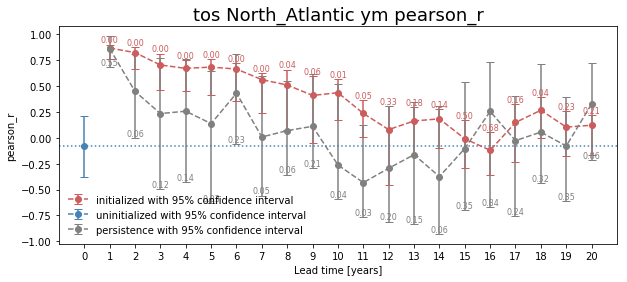

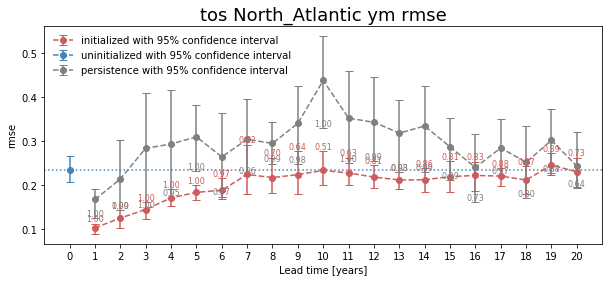

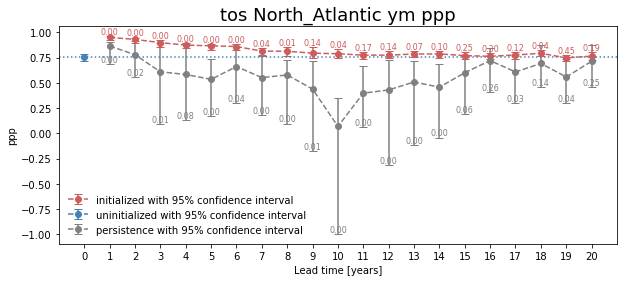

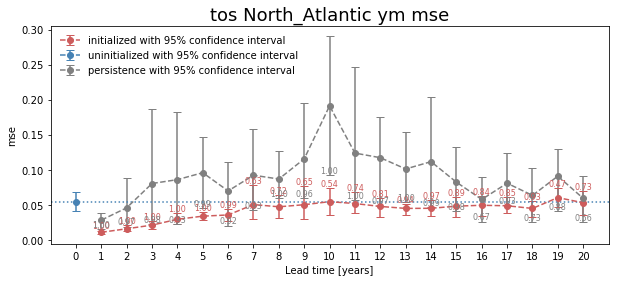

In [9]:
for metric in ['pearson_r', 'rmse', 'ppp', 'mse']:
    bootstrapped = bootstrap_perfect_model(ds_, control_, metric=metric, 
                                           comparison=comparison, bootstrap=bootstrap, 
                                           sig=sig)

    plot_bootstrapped_skill_over_leadyear(bootstrapped, sig)
    plt.title(' '.join([varname, area, period, metric]),fontsize=18)
    plt.ylabel(metric)
    plt.show()

## Different comparisons lead to different skill score magnitude by design

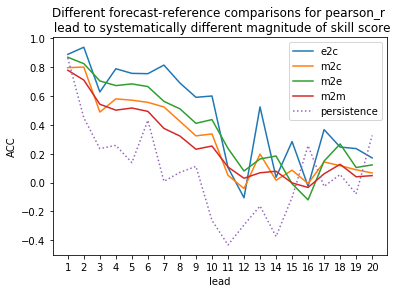

In [10]:
for c in ['e2c','m2c','m2e','m2m']:
    compute_perfect_model(ds_, control_, metric='pearson_r', comparison=c).plot(label=c)
compute_persistence(ds_, control_).plot(label='persistence', ls=':')
plt.ylabel('ACC')
plt.xticks(np.arange(1,21))
plt.legend()
plt.title('Different forecast-reference comparisons for pearson_r \n lead to systematically different magnitude of skill score')
plt.show()

# 3-dimensional

Data is stored on curvilinear grid: lon(y, x), lat(y, x). The computation of skill is independent of any extra dimensions to `init`, `member`, `lead`.

In [11]:
ds3d = open_dataset('MPI-PM-DP-3D').sel(init=3014).expand_dims('init')[varname]
control3d = open_dataset('MPI-control-3D')[varname]

#### Choose predictability metric and comparison

In [12]:
metric='rmse'
comparison='m2e'

## Skill over lead year

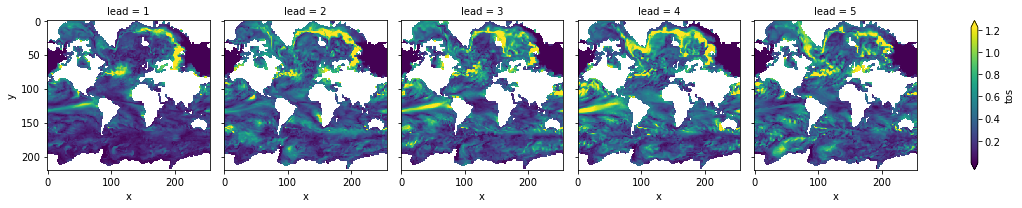

In [13]:
compute_perfect_model(ds3d, control3d, metric=metric, comparison=comparison).plot(col='lead', robust=True, yincrease=False)

## Significant skill based on bootstrapping

In [14]:
bootstrapped3d = bootstrap_perfect_model(ds3d, control3d, metric=metric, comparison=comparison, 
                     sig=sig, bootstrap=bootstrap)

In [15]:
init_skill_better_than_pers = bootstrapped3d.sel(results='skill',kind='init').where(bootstrapped3d.sel(results='p',kind='pers')>0.05)
init_skill_better_than_uninit = bootstrapped3d.sel(results='skill',kind='init').where(bootstrapped3d.sel(results='p',kind='uninit')>0.05)

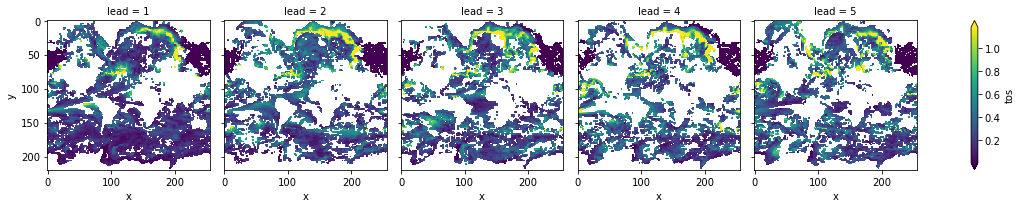

In [16]:
init_skill_better_than_pers.plot(col='lead', robust=True, yincrease=False)

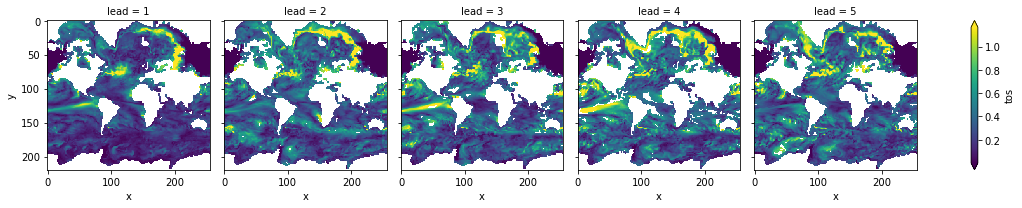

In [17]:
init_skill_better_than_uninit.plot(col='lead', robust=True, yincrease=False)

# Slow components of internal variability indicating potential predictability

Set of methods to show regions indicating chances for decadal predictability:
- Decadal Potential Predictability
- Variance-weighted mean period
- Lag1 autocorrelation
- Decorrelation time

## DPP

In [18]:
help(DPP)

Help on function DPP in module climpred.stats:

DPP(ds, m=10, chunk=True)
    Calculate Diagnostic Potential Predictability (DPP) as potentially
    predictable variance fraction (ppvf) in Boer 2004.
    
    Note: Resplandy et al. 2015 and Seferian et al. 2018 calculate unbiased DPP
    in a slightly different way. chunk=False
    
    .. math::
    
    DPP_{       ext{unbiased}}(m)=rac{\sigma^2_m - 1/m \cdot \sigma^2}{\sigma^2}
    
    References:
    * Boer, G. J. “Long Time-Scale Potential Predictability in an Ensemble of
        Coupled Climate Models.” Climate Dynamics 23, no. 1 (August 1, 2004):
        29–44. https://doi.org/10/csjjbh.
    * Resplandy, L., R. Séférian, and L. Bopp. “Natural Variability of CO2 and
        O2 Fluxes: What Can We Learn from Centuries-Long Climate Models
        Simulations?” Journal of Geophysical Research: Oceans 120, no. 1
        (January 2015): 384–404. https://doi.org/10/f63c3h.
    * Séférian, Roland, Sarah Berthet, and Matthieu Chevallie

### Resplandy 2015, Seferian 2018 method

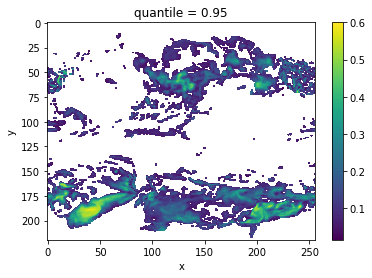

In [19]:
threshold = DPP_threshold(control3d, m=10, chunk=False, bootstrap=bootstrap)
DPP10 = DPP(control3d, m=10, chunk=False)
DPP10.where(DPP10>threshold).plot(yincrease=False,vmax=.6, cmap='viridis')

### Original Boer 2004 implementation

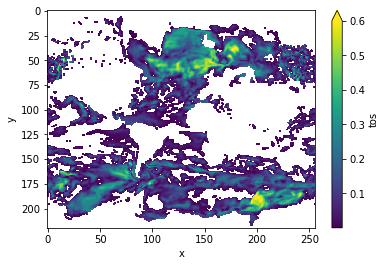

In [20]:
threshold = DPP_threshold(control3d, m=10, chunk=True, bootstrap=bootstrap)
DPP10 = DPP(control3d, m=10, chunk=True)
DPP10.where(DPP10>0).plot(yincrease=False,vmax=.6, cmap='viridis')

yields similar results

## varweigthed mean period

In [21]:
help(xr_varweighted_mean_period)

Help on function xr_varweighted_mean_period in module climpred.stats:

xr_varweighted_mean_period(ds, time_dim='time')
    Calculate the variance weighted mean period of time series.
    
    ..math:
        P_x = \sum_k V(f_k,x) / \sum_k f_k V(f_k,x)
    
    Reference:
      * Branstator, Grant, and Haiyan Teng. “Two Limits of Initial-Value
        Decadal Predictability in a CGCM." Journal of Climate 23, no. 23
        (August 27, 2010): 6292-6311. https://doi.org/10/bwq92h.
    
    Args:
        ds (xarray object): Time series.
        time_dim (optional str): Name of time dimension.



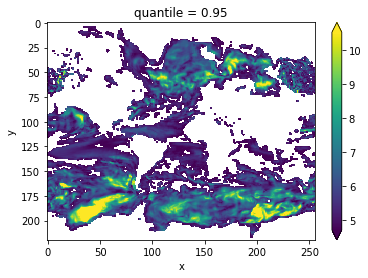

In [22]:
threshold = xr_varweighted_mean_period_threshold(control3d, bootstrap=bootstrap)
varweighted_mean_period = xr_varweighted_mean_period(control3d,time_dim='time')
varweighted_mean_period.where(varweighted_mean_period > threshold).plot(yincrease=False, robust=True)

## Lag1 autocorrelation

In [23]:
help(xr_autocorr)

Help on function xr_autocorr in module climpred.stats:

xr_autocorr(ds, lag=1, dim='time', return_p=False)
    Calculate the lagged correlation of time series.
    
    Args:
        ds (xarray object): Time series or grid of time series.
        lag (optional int): Number of time steps to lag correlate to.
        dim (optional str): Name of dimension to autocorrelate over.
        return_p (optional bool): If True, return correlation coefficients
                                  and p values.
    
    Returns:
        Pearson correlation coefficients.
    
        If return_p, also returns their associated p values.



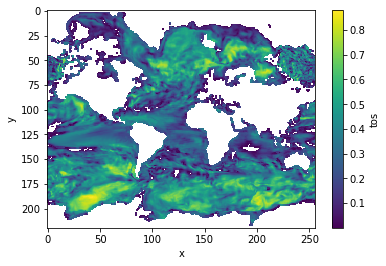

In [24]:
corr_ef = xr_autocorr(control3d,dim='time')
corr_ef.where(corr_ef>0).plot(yincrease=False, robust=False)

## Decorrelation time

In [25]:
help(xr_decorrelation_time)

Help on function xr_decorrelation_time in module climpred.stats:

xr_decorrelation_time(da, r=20, dim='time')
    Calculate the decorrelaton time of a time series.
    
    .. math::
        tau_{d} = 1 + 2 * \sum_{k=1}^{\inf}(alpha_{k})^{k}
    
    Reference:
        * Storch, H. v, and Francis W. Zwiers. Statistical Analysis in Climate
          Research. Cambridge ; New York: Cambridge University Press, 1999.,
          p.373
    
    Args:
        da (xarray object): Time series.
        r (optional int): Number of iterations to run the above formula.
        dim (optional str): Time dimension for xarray object.
    
    Returns:
        Decorrelation time of time series.



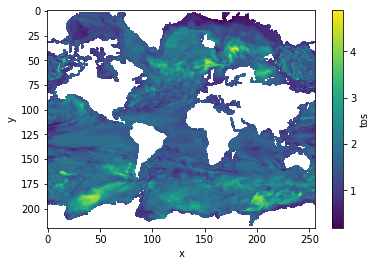

In [26]:
decorr_time = xr_decorrelation_time(control3d)
decorr_time.where(decorr_time>0).plot(yincrease=False, robust=False)